# 5.2 Bivariate SU Distribution

- [1. Functions](#1.-Functions)
- [2. SCF Data](#2.-SCF-Data)
- [3. 2022년 College Graduates](#3.-2022년-College-Graduates)
- [4. 2022년 상관계수 추정](#4.-2022년-상관계수-추정)
- [5. 연도별 Gini 및 상관계수 추정](#5.-연도별-Gini-및-상관계수-추정)

## 1. Functions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt

### PDFs

In [2]:
def SU_pdf(x, m, s, lambda_, theta):

    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta
    pdf_vals = J*st.norm.pdf(z)
    
    return pdf_vals

In [3]:
def SU_bi_pdf(x1, x2, m1, m2, s1, s2, lambda1, lambda2, theta1, theta2, r):

    J = 1/( (theta1*np.sqrt((x1-m1)**2+s1**2))*(theta2*np.sqrt((x2-m1)**2+s2**2)) )
    z1 = (np.arcsinh((x1 - m1)/s1) - lambda1)/theta1
    z2 = (np.arcsinh((x2 - m2)/s2) - lambda2)/theta2
    pdf_vals = 1/(2*np.pi*np.sqrt(1-r**2))*J*np.exp(
        -1/(2*(1-r**2))*(z1**2+z2**2-2*r*z1*z2))
    
    return pdf_vals

In [4]:
def SU_cond_pdf(x1, x2, m1, m2, s1, s2, lambda1, lambda2, theta1, theta2, r):
    '''
    Conditional PDF of x1 given x2
    '''    
    
    lambda1_star = lambda1 + r * theta1/theta2 * (np.arcsinh((x2 - m2) / s2) - lambda2)
    theta1_star = theta1 * (1 - r**2)**(1/2)

    J = 1/(theta1_star*np.sqrt((x1-m1)**2+s1**2))
    z = (np.arcsinh((x1 - m1)/s1) - lambda1_star)/theta1_star
    pdf_vals = J*st.norm.pdf(z)
    
    return pdf_vals

### Log Likelihood Functions

`s`($s$)와 `theta`($\theta$)가 항상 양수이기 때문에 최적화 과정에서 이 조건을 부과하기 위해 이들 파라미터에 지수(natural exponential)를 취해서 로그가능도 함수를 만드는 방법을 사용한다. 이렇게 하면 입력 파라미터는 제약(bounding) 조건이 사라지고 모든 실수값을 취할 수 있게 된다.

**일변량 단순**

In [5]:
def ll_SU_e(x, m, s, lambda_, theta):

    s = np.exp(s)
    theta = np.exp(theta)
    
    J = 1/(theta*np.sqrt((x-m)**2+s**2))
    z = (np.arcsinh((x - m)/s) - lambda_)/theta

    ln_pdf_vals = (np.log(J) - 0.5*np.log(2*np.pi) - 0.5*(z)**2)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

**이변량 가중**

In [6]:
def  weight_ll_bi_SU_e(x1, x2, weight, m1, m2, s1, s2, lambda1, lambda2, theta1, theta2, r):

    s1 = np.exp(s1)
    theta1 = np.exp(theta1)
    s2 = np.exp(s2)
    theta2 = np.exp(theta2)
    
    J = 1/( (theta1*np.sqrt((x1-m1)**2+s1**2))*(theta2*np.sqrt((x2-m2)**2+s2**2)) )
    z1 = (np.arcsinh((x1 - m1)/s1) - lambda1)/theta1
    z2 = (np.arcsinh((x2 - m2)/s2) - lambda2)/theta2
    
    ln_pdf_vals = weight*( np.log(J) - np.log(2*np.pi) - 0.5*np.log(1-r**2)
                          - 0.5/(1-r**2)*(z1**2+z2**2-2*r*z1*z2) )
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

### MLE Objective Functions

**일변량 단순**

In [7]:
def obj_SU_e(params, *args):

    m, s, lambda_, theta = params
    x = args
    
    log_lik_val = ll_SU_e(x, m, s, lambda_, theta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

**이변량 가중**

In [8]:
def weight_obj_bi_SU_e(params, *args):

    m1, s1, lambda1, theta1, m2, s2, lambda2, theta2, r = params
    x1, x2, weight = args
    log_lik_val = weight_ll_bi_SU_e(x1, x2, weight, m1, m2, s1, s2, lambda1, lambda2, theta1, theta2, r)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

### Statistics

In [9]:
def SU_mean(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    mean = m + s*w**(0.5)*np.sinh(lambda_)

    return mean

def SU_var(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    variance = 0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1) 

    return variance

def SU_skew(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    sigma = (0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1))**(0.5)
    mu_3 = 0.25*(s**3)*w**(0.5)*(w-1)**2*(w*(w+2)*np.sinh(3*lambda_)+3*np.sinh(lambda_))
    skewness = mu_3/(sigma**3)
        
    return skewness

def SU_kurt(m, s, lambda_, theta):
    
    w = np.exp(theta**2)
    sigma = (0.5*(s**2)*(w-1)*(w*np.cosh(2*lambda_)+1))**(0.5)
    mu_4 = 0.125*(s**4)*(w-1)**2*((w**2)*(w**4+2*w**3+3*w**2-3)*np.cosh(4*lambda_)
                                  + 4*(w**2)*(w+2)*np.cosh(2*lambda_) 
                                  + 3*(2*w+1))
    kurtosis = mu_4/(sigma**4)
        
    return kurtosis

In [10]:
# Pearson Correlation

def SU_P_corr(lambda1, lambda2, theta1, theta2, r):
    
    w1 = np.exp(theta1**2)
    w2 = np.exp(theta2**2)
    sigma1 = np.sqrt(0.5*(w1-1)*(w1*np.cosh(2*lambda1)+1)) 
    sigma2 = np.sqrt(0.5*(w2-1)*(w2*np.cosh(2*lambda2)+1)) 
    rho = (
        np.exp(0.5*(theta1**2+theta2**2))/(sigma1*sigma2)*
        (0.5*np.exp(r*theta1*theta2)*np.cosh(lambda1+lambda2)
         -0.5*np.exp(-r*theta1*theta2)*np.cosh(lambda1-lambda2)
         -np.sinh(lambda1)*np.sinh(lambda2))
    )
    
    return rho

# Normalized Correlation

def SU_N_corr(lambda1, lambda2, theta1, theta2, rho):
    
    w1 = np.exp(theta1**2)
    w2 = np.exp(theta2**2)
    sigma1 = np.sqrt(0.5*(w1-1)*(w1*np.cosh(2*lambda1)+1)) 
    sigma2 = np.sqrt(0.5*(w2-1)*(w2*np.cosh(2*lambda2)+1))
    B = (rho*sigma1*sigma2*np.exp(-0.5*(theta1**2+theta2**2)) 
         + np.sinh(lambda1)*np.sinh(lambda2))

    r = 1/(theta1*theta2)*np.log(
        (B+np.sqrt(B**2+np.cosh(lambda1+lambda2)*np.cosh(lambda1-lambda2)))/
        np.cosh(lambda1+lambda2))
    
    return r

### Weighted Statistics

In [11]:
import numpy as np
from scipy.stats import moment

def weighted_mean(x, weights):
    return np.sum(x * weights) / np.sum(weights)

def weighted_moment(data, weights, order):
    mean = weighted_mean(data, weights)
    return np.sum(weights * (data - mean) ** order) / np.sum(weights)

def weighted_std(data, weights):
    mean = weighted_mean(data, weights)
    variance = np.sum(weights * ((data - mean) ** 2)) / np.sum(weights)
    return np.sqrt(variance)

def weighted_skewness(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m3 = weighted_moment(data, weights, 3)
    skewness = (np.sqrt(np.sum(weights)) * m3) / (m2 ** 1.5)
    return skewness

def weighted_kurtosis(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m4 = weighted_moment(data, weights, 4)
    kurtosis = (np.sum(weights) * m4) / (m2 ** 2)
    return kurtosis

In [12]:
import numpy as np

def weighted_pearson_corr(x, y, weights):

    # 가중 평균 계산
    mean_x = np.average(x, weights=weights)
    mean_y = np.average(y, weights=weights)
    
    # 가중치가 적용된 공분산 계산
    cov_xy = np.average((x - mean_x) * (y - mean_y), weights=weights)
    
    # 가중치가 적용된 x와 y의 분산 계산
    var_x = np.average((x - mean_x)**2, weights=weights)
    var_y = np.average((y - mean_y)**2, weights=weights)
    
    # 가중 Pearson 상관계수 계산
    corr_xy = cov_xy / np.sqrt(var_x * var_y)
    
    return corr_xy

## 2. SCF Data

- [Survey of Consumer Finances (SCF)](https://www.federalreserve.gov/econres/scfindex.htm)
- [Code Book](https://sda.berkeley.edu/sdaweb/analysis/?dataset=scfcomb2022)

In [13]:
import pandas as pd
import requests
import io
import zipfile     #Three packages we'll need to unzip the data

def unzip_survey_file(year):
    import requests, io, zipfile
    import pandas as pd
    
    if int(year) <1989:
        url = 'http://www.federalreserve.gov/econresdata/scf/files/'\
        +year+'_scf'+year[2:]+'bs.zip'
    else: 
        url = 'http://www.federalreserve.gov/econres/files/scfp'+year+'s.zip'    

    url = requests.get(url)
    url_unzipped = zipfile.ZipFile(io.BytesIO(url.content))
    
    return url_unzipped.extract(url_unzipped.namelist()[0])

In [14]:
import pandas as pd

# 처리할 연도 목록 정의
years = ['1989', '1992', '1995', '1998',
         '2001', '2004', '2007', '2010', '2013', '2016', '2019', '2022']

# 결과를 저장할 딕셔너리 초기화
networth_dict = {}
income_dict = {}
age_dict = {}
weight_dict = {}

for year in years:
    # 데이터 로드
    scf_data = pd.read_stata(unzip_survey_file(year=year))
    
    # 변수 추출 및 딕셔너리에 저장
    networth_dict[f'networth_{year}'] = scf_data['networth'] / 1000000
    income_dict[f'income_{year}'] = scf_data['income'] / 1000000
    age_dict[f'age_{year}'] = scf_data['age']
    weight_dict[f'weight_{year}'] = scf_data['wgt']
    
# 사용 예시: networth_2022 변수에 접근
networth_2022 = networth_dict['networth_2022']
income_2022 = income_dict['income_2022']
age_2022 = age_dict['age_2022']
weight_2022 = weight_dict['weight_2022']

## 3. 2022년 College Graduates

**Empty Dataframe**

In [15]:
columns = ['x1_mean', 'x1_std', 
           'x2_mean', 'x2_std', 
           'Pearson_corr', 'Normalized_corr']
df_stats = pd.DataFrame(columns=columns, index=['Empirical', 'Model-based'])

columns = ['N', 'min', 'max', 'mean', 'std']
df_empirical = pd.DataFrame(columns=columns, index=[22, 23, 24, '22-24'])

columns = ['mean', 'std']
df_model = pd.DataFrame(columns=columns, index=[22, 23, 24, '22-24'])

### Data

In [16]:
year = 2022

In [17]:
x1 = networth_dict[f'networth_{year}']
x1

0        0.7621
1        0.8543
2        0.6782
3        0.2796
4        0.6026
          ...  
22970    0.0000
22971    0.0000
22972    0.0000
22973    0.0000
22974    0.0000
Name: networth, Length: 22975, dtype: float64

In [18]:
x2 = age_dict[f'age_{year}']
x2

0        70
1        70
2        70
3        70
4        70
         ..
22970    40
22971    40
22972    40
22973    40
22974    40
Name: age, Length: 22975, dtype: int8

In [19]:
unique_values, counts = np.unique(x2, return_counts=True)
for i, (value, count) in enumerate(zip(unique_values, counts)):
    if i >= 10:  # 10개까지만 출력
        break
    print(f"Value: {value}, Count: {count/5}")

Value: 18, Count: 1.0
Value: 19, Count: 7.0
Value: 20, Count: 9.0
Value: 21, Count: 22.0
Value: 22, Count: 24.0
Value: 23, Count: 27.0
Value: 24, Count: 21.0
Value: 25, Count: 41.0
Value: 26, Count: 45.0
Value: 27, Count: 40.0


In [20]:
weight = weight_dict[f'weight_{year}']
w = weight/(weight.sum())

### 이변량 추정

**Empirical Estimates**

In [21]:
# x1 통계량
x1_mean = weighted_mean(x1, w)
x1_std = weighted_std(x1, w)

# x2 통계량
x2_mean = weighted_mean(x2, w)
x2_std = weighted_std(x2, w)

# Pearson 상관계수
pearson_corr = weighted_pearson_corr(x1, x2, w)
    
# 결과 입력 및 출력
df_stats.loc['Empirical'] = {
    'x1_mean': x1_mean, 'x1_std': x1_std,
    'x2_mean': x2_mean, 'x2_std': x2_std,
    'Pearson_corr': pearson_corr
}
print(df_stats.loc['Empirical'])

x1_mean             1.059457
x1_std              8.085433
x2_mean            52.447907
x2_std             17.609608
Pearson_corr        0.071318
Normalized_corr          NaN
Name: Empirical, dtype: object


**SU Model-based Estimates**

In [22]:
m1_init = 0
s1_init = 0
lambda1_init = 0
theta1_init = 0
m2_init = 0
s2_init = 0
lambda2_init = 0
theta2_init = 0
r = 0
params_init = np.array([m1_init, s1_init, lambda1_init, theta1_init,
                       m2_init, s2_init, lambda2_init, theta2_init, r])
mle_args = (x1,x2,w)
res_bi_SU = opt.minimize(weight_obj_bi_SU_e, params_init, args=mle_args,
                         method='L-BFGS-B',
                         bounds=[(None, None)] * 8 + [(-.99, .99)])

(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE,
 m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE, r_MLE)=res_bi_SU.x

s1_MLE = np.exp(s1_MLE)
theta1_MLE = np.exp(theta1_MLE)
s2_MLE = np.exp(s2_MLE)
theta2_MLE = np.exp(theta2_MLE)

result = {'m1': [m1_MLE], 's1': [s1_MLE], 
          'lambda1': [lambda1_MLE], 'theta1': [theta1_MLE],
          'm2': [m2_MLE], 's2': [s2_MLE],
          'lambda2': [lambda2_MLE], 'theta2': [theta2_MLE], 'r': [r_MLE]}
df = pd.DataFrame(result)
df.T

,0
m1,-0.004508
s1,0.015383
lambda1,3.021377
theta1,2.076760
m2,-2.300825
s2,123.780052
lambda2,0.425655
theta2,0.129500
r,0.344697


In [23]:
res_bi_SU

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.747951188349125
        x: [-4.508e-03 -4.175e+00  3.021e+00  7.308e-01 -2.301e+00
             4.819e+00  4.257e-01 -2.044e+00  3.447e-01]
      nit: 123
      jac: [ 1.405e-04  1.082e-04  2.824e-05  2.035e-04  5.258e-05
             7.763e-05  2.538e-04 -8.358e-05  2.203e-04]
     nfev: 1500
     njev: 150
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [24]:
# x1 통계량
x1_mean = SU_mean(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE)
x1_std = SU_var(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE)**0.5

# x2 통계량
x2_mean = SU_mean(m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE)
x2_std = SU_var(m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE)**0.5

# Pearson 상관계수
pearson_corr = SU_P_corr(lambda1_MLE, lambda2_MLE, theta1_MLE, theta2_MLE, r_MLE)

# Normalized_corr
Normalized_corr = r_MLE

In [25]:
# 결과 입력 및 출력
df_stats.loc['Model-based'] = {
    'x1_mean': x1_mean, 'x1_std': x1_std, 
    'x2_mean': x2_mean, 'x2_std': x2_std, 
    'Pearson_corr': pearson_corr, 'Normalized_corr': Normalized_corr
}
print(df_stats.loc['Model-based'])

x1_mean             1.355931
x1_std             11.704146
x2_mean            52.449382
x2_std             17.663421
Pearson_corr        0.085214
Normalized_corr     0.344697
Name: Model-based, dtype: object


### age=22 순자산 분포

In [26]:
age = 22

**해당 연령 관측만 사용해 계산**

In [27]:
# 필터링된 x1과 weight
x1_given_x2 = x1[x2 == age]
w_given_x2 = w[x2 == age]

empirical_mean = weighted_mean(x1_given_x2, w_given_x2)
empirical_std = weighted_std(x1_given_x2, w_given_x2)

df_empirical.loc[age] = {
    'N': len(x1_given_x2)/5, 'min': min(x1_given_x2), 'max': max(x1_given_x2), 
    'mean': empirical_mean, 'std': empirical_std,
}
print(df_empirical.loc[age])

N           24.0
min      -0.0086
max       5.4134
mean    0.121863
std     0.471756
Name: 22, dtype: object


**Empirical vs. Model-based 분포**

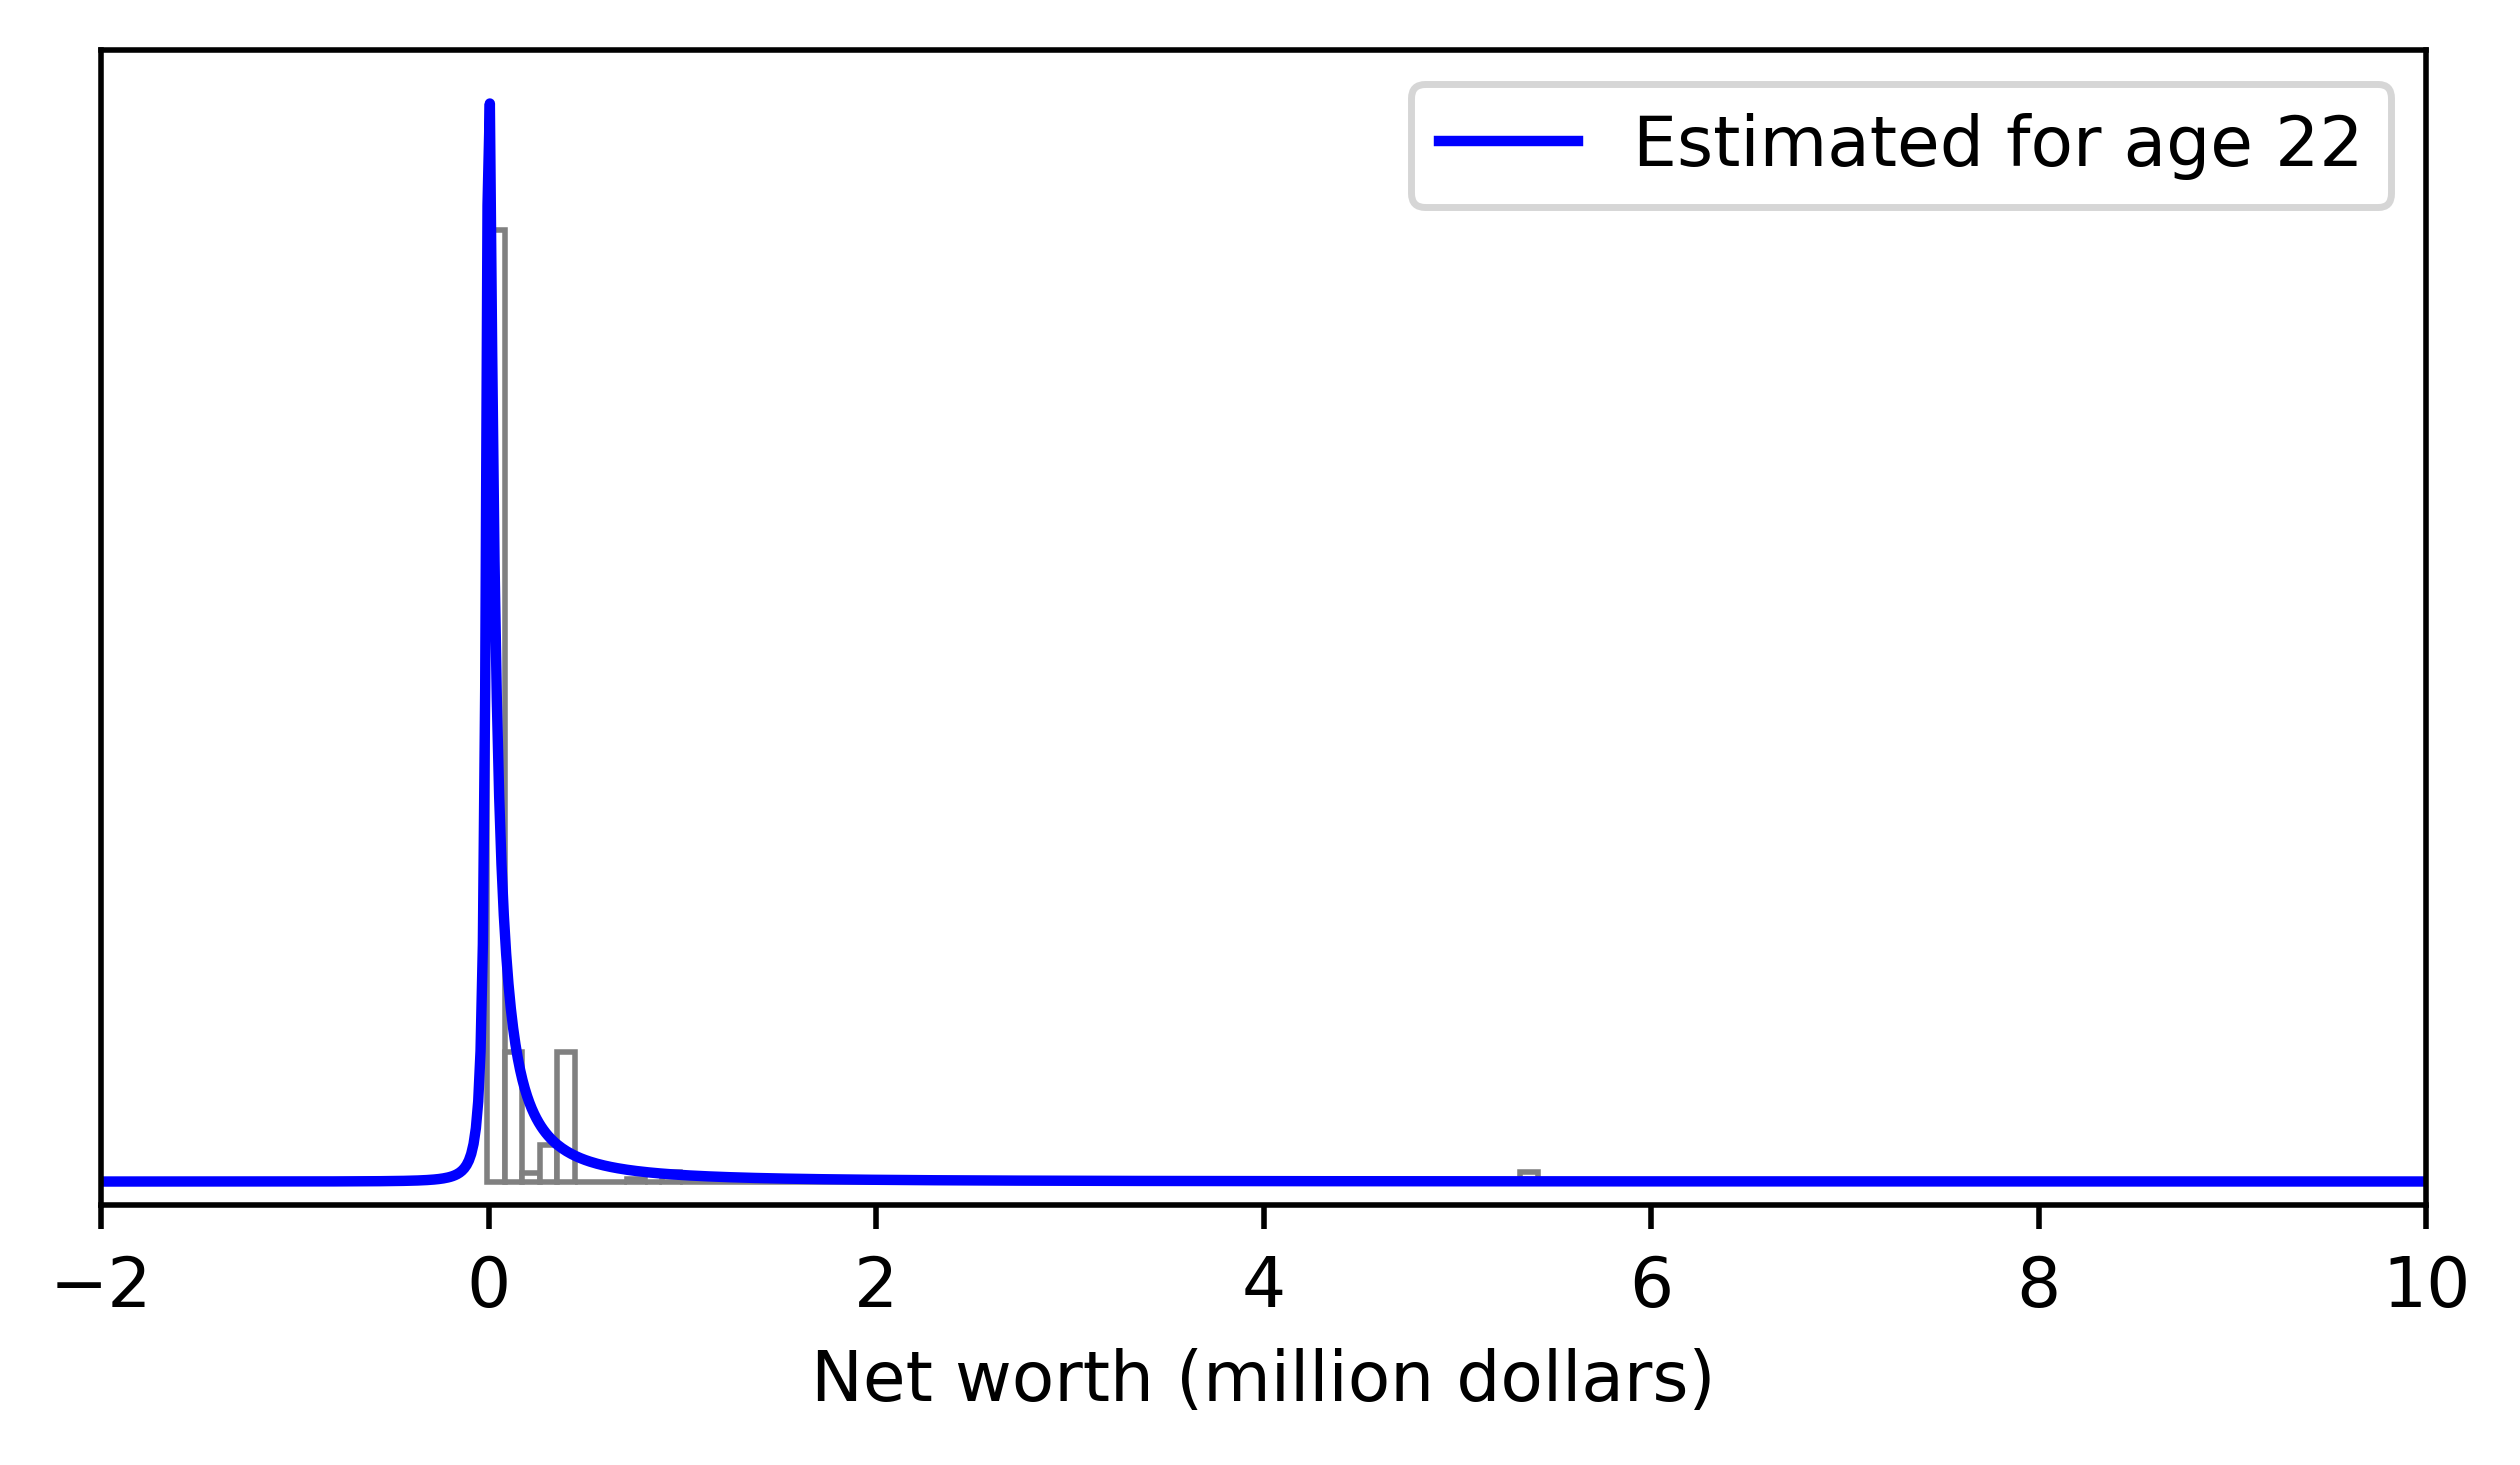

In [28]:
plt.figure(figsize=(6, 3), dpi=500)

plt.xlabel('Net worth (million dollars)')

num_bins = 60
plt.hist(x1_given_x2, num_bins, weights=w_given_x2, density=True,
         linewidth=0.8, color='w', edgecolor='grey')
plt.xlim([-2, 10])

dist_X = np.linspace(-2, 10, 1000)
plt.plot(dist_X, SU_cond_pdf(dist_X, age, m1_MLE, m2_MLE, s1_MLE, s2_MLE,
                             lambda1_MLE, lambda2_MLE, theta1_MLE, theta2_MLE, r_MLE),
         linewidth=1.5, linestyle='solid', color='b', label='Estimated for age 22')

plt.legend(loc='upper right')
plt.ylim(-0.2, None)
plt.yticks([]) # y축 틱 레이블 제거

plt.show()

In [29]:
lambda1_star = lambda1_MLE + r_MLE * theta1_MLE/theta2_MLE *\
                (np.arcsinh((age - m2_MLE) / s2_MLE) - lambda2_MLE)
theta1_star = theta1_MLE * (1 - r_MLE**2)**(1/2)

print('lambda1_star =',lambda1_star)
print('theta1_star =',theta1_star)

lambda1_star = 1.7468164813446627
theta1_star = 1.9494837156271407


In [30]:
model_mean = SU_mean(m1_MLE, s1_MLE, lambda1_star, theta1_star)
model_std = SU_var(m1_MLE, s1_MLE, lambda1_star, theta1_star)**0.5

In [31]:
df_model.loc[age] = {
    'mean': model_mean, 'std': model_std
}
print(df_model.loc[age])

mean    0.281579
std      1.95322
Name: 22, dtype: object


### age=23 순자산 분포

In [32]:
age = 23

**해당 연령 관측만 사용해 계산**

In [33]:
# 필터링된 x1과 weight
x1_given_x2 = x1[x2 == age]
w_given_x2 = w[x2 == age]

empirical_mean = weighted_mean(x1_given_x2, w_given_x2)
empirical_std = weighted_std(x1_given_x2, w_given_x2)

df_empirical.loc[age] = {
    'N': len(x1_given_x2)/5, 'min': min(x1_given_x2), 'max': max(x1_given_x2), 
    'mean': empirical_mean, 'std': empirical_std,
}
print(df_empirical.loc[age])

N           27.0
min      -0.1556
max       0.4164
mean    0.040808
std     0.096606
Name: 23, dtype: object


**Empirical vs. Model-based 분포**

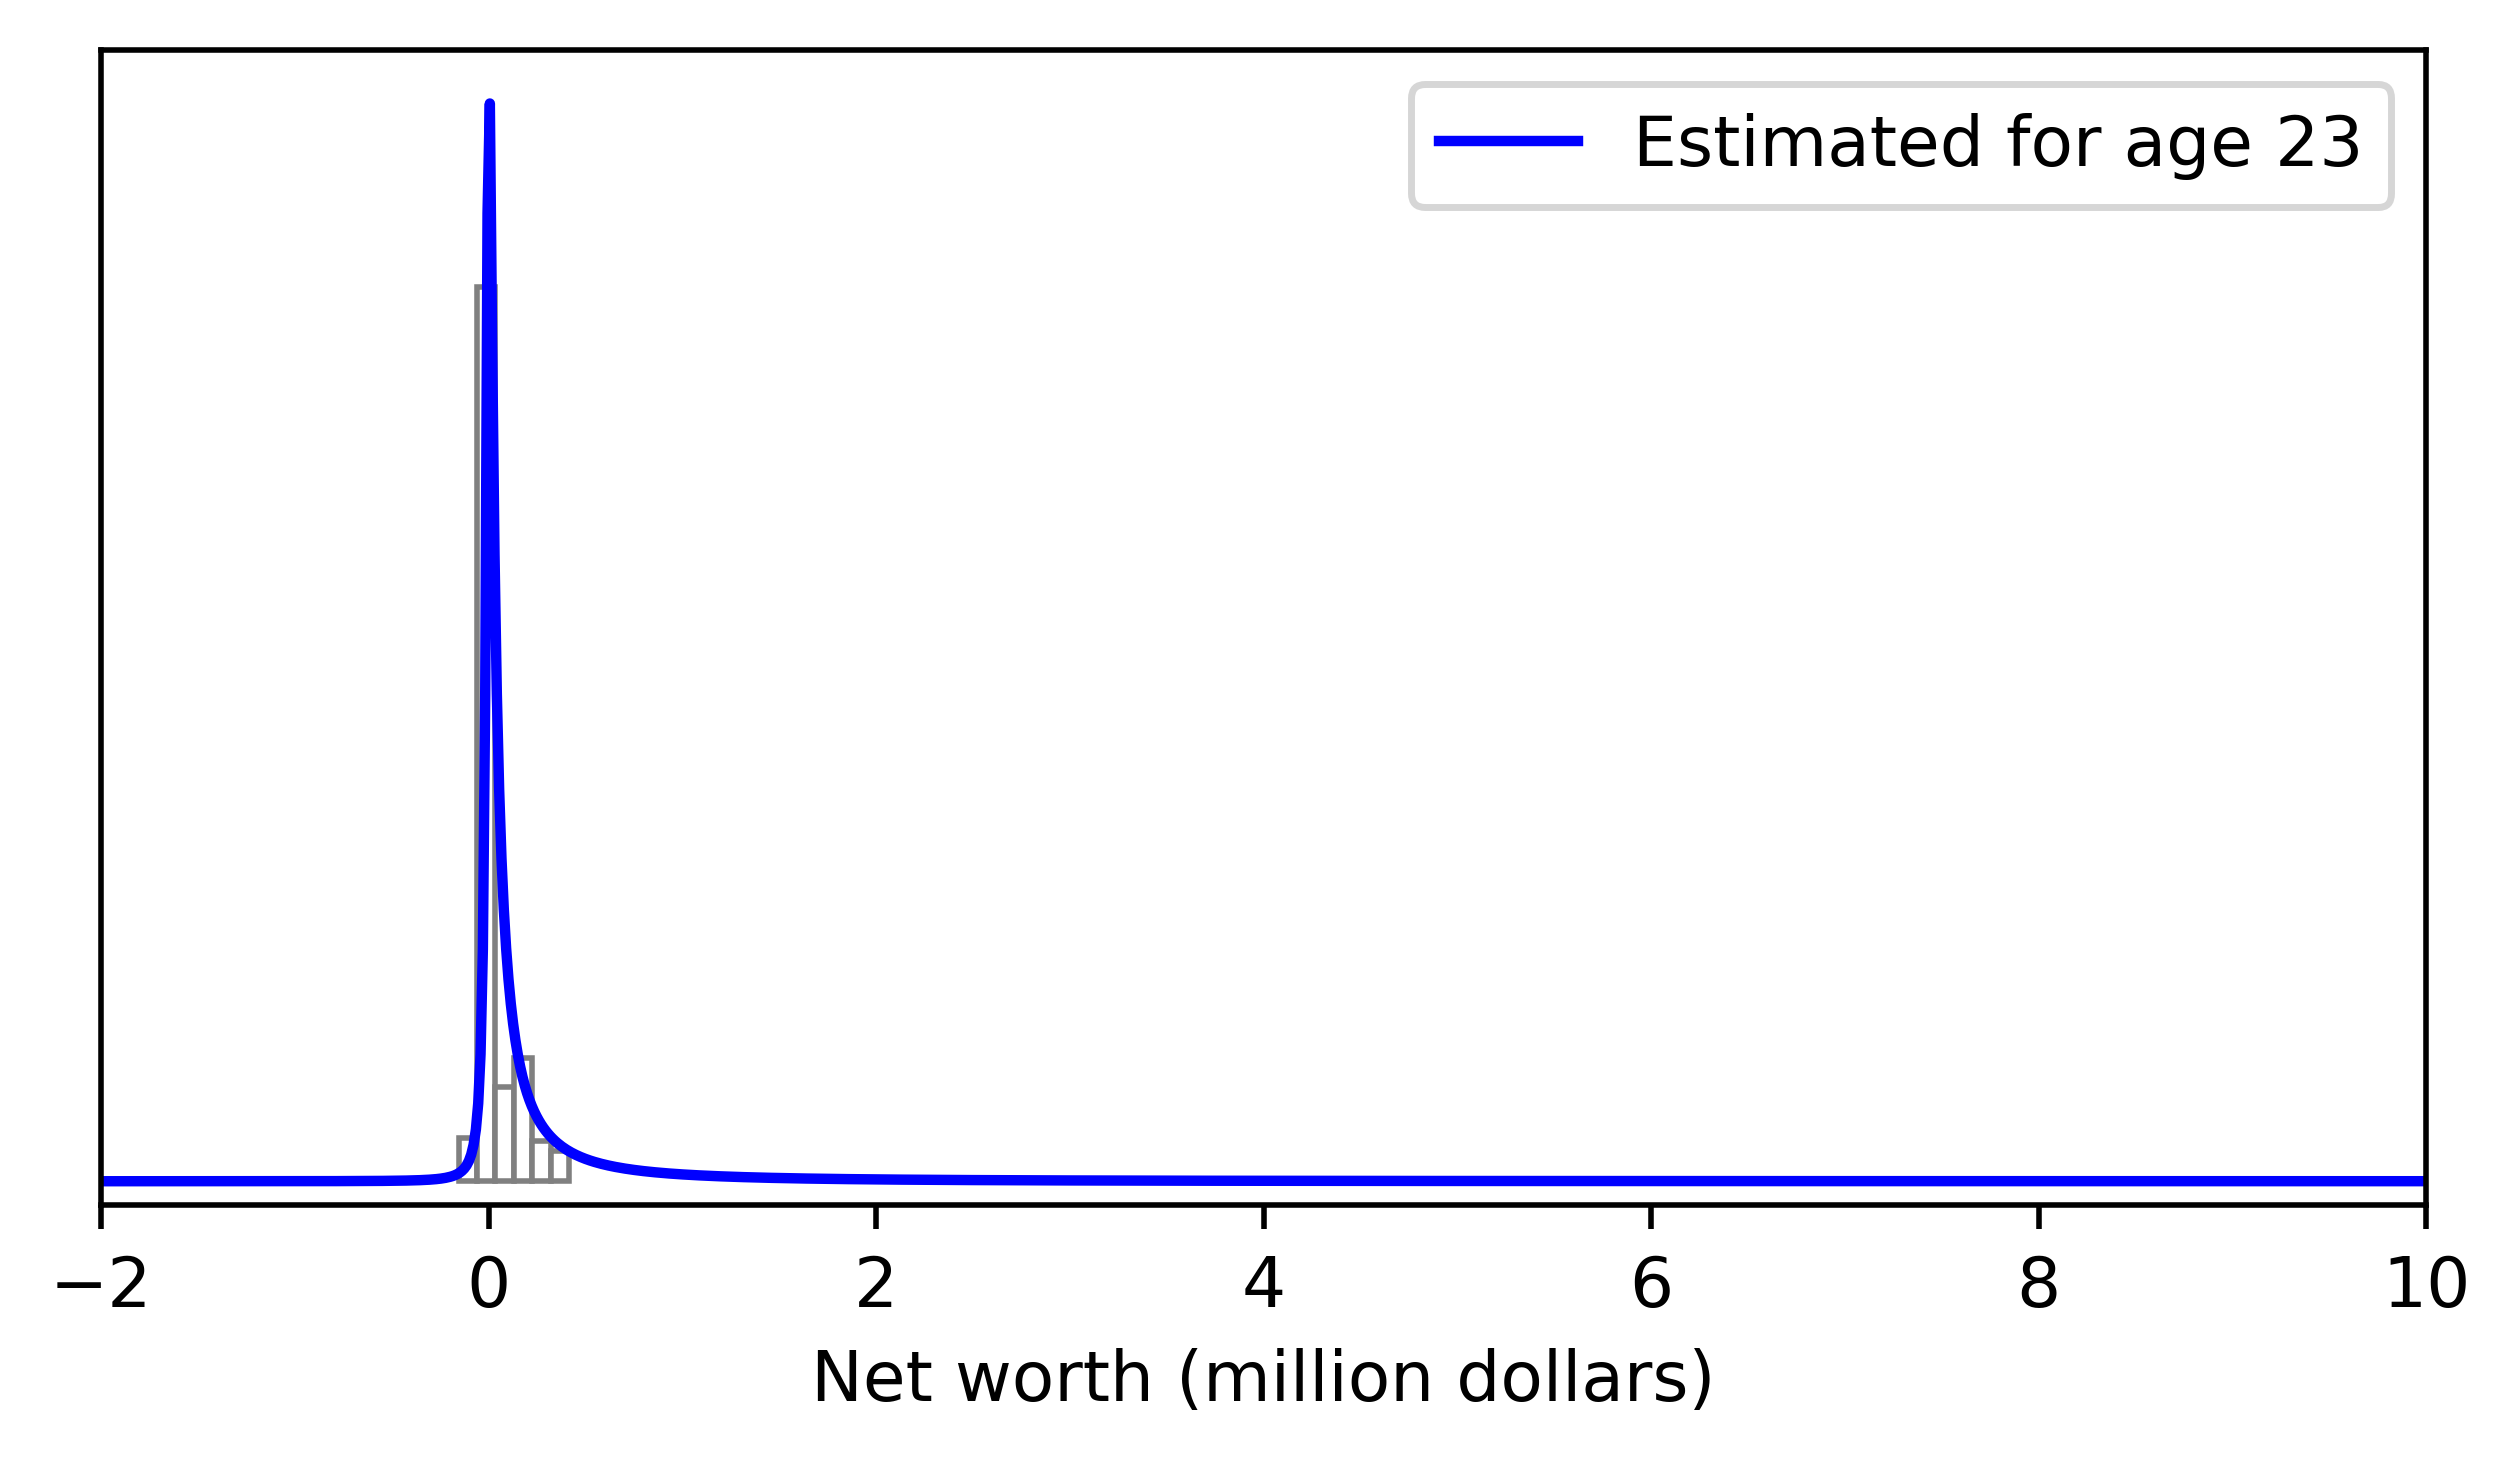

In [34]:
plt.figure(figsize=(6, 3), dpi=500)

plt.xlabel('Net worth (million dollars)')

num_bins = 6
plt.hist(x1_given_x2, num_bins, weights=w_given_x2, density=True,
         linewidth=0.8, color='w', edgecolor='grey')
plt.xlim([-2, 10])

dist_X = np.linspace(-2, 10, 1000)
plt.plot(dist_X, SU_cond_pdf(dist_X, age, m1_MLE, m2_MLE, s1_MLE, s2_MLE,
                             lambda1_MLE, lambda2_MLE, theta1_MLE, theta2_MLE, r_MLE),
         linewidth=1.5, linestyle='solid', color='b', label='Estimated for age 23')

plt.legend(loc='upper right')
plt.ylim(-0.2, None)
plt.yticks([]) # y축 틱 레이블 제거

plt.show()

In [35]:
lambda1_star = lambda1_MLE + r_MLE * theta1_MLE/theta2_MLE *\
                (np.arcsinh((age - m2_MLE) / s2_MLE) - lambda2_MLE)
theta1_star = theta1_MLE * (1 - r_MLE**2)**(1/2)

print('lambda1_star =',lambda1_star)
print('theta1_star =',theta1_star)

lambda1_star = 1.7906045228619485
theta1_star = 1.9494837156271407


In [36]:
model_mean = SU_mean(m1_MLE, s1_MLE, lambda1_star, theta1_star)
model_std = SU_var(m1_MLE, s1_MLE, lambda1_star, theta1_star)**0.5

In [37]:
df_model.loc[age] = {
    'mean': model_mean, 'std': model_std
}
print(df_model.loc[age])

mean     0.29517
std     2.040381
Name: 23, dtype: object


### age=24 순자산 분포

In [38]:
age = 24

**해당 연령 관측만 사용해 계산**

In [39]:
# 필터링된 x1과 weight
x1_given_x2 = x1[x2 == age]
w_given_x2 = w[x2 == age]

empirical_mean = weighted_mean(x1_given_x2, w_given_x2)
empirical_std = weighted_std(x1_given_x2, w_given_x2)

df_empirical.loc[age] = {
    'N': len(x1_given_x2)/5, 'min': min(x1_given_x2), 'max': max(x1_given_x2), 
    'mean': empirical_mean, 'std': empirical_std,
}
print(df_empirical.loc[age])

N           21.0
min     -0.04626
max       9.5763
mean    0.385618
std     1.638101
Name: 24, dtype: object


**Empirical vs. Model-based 분포**

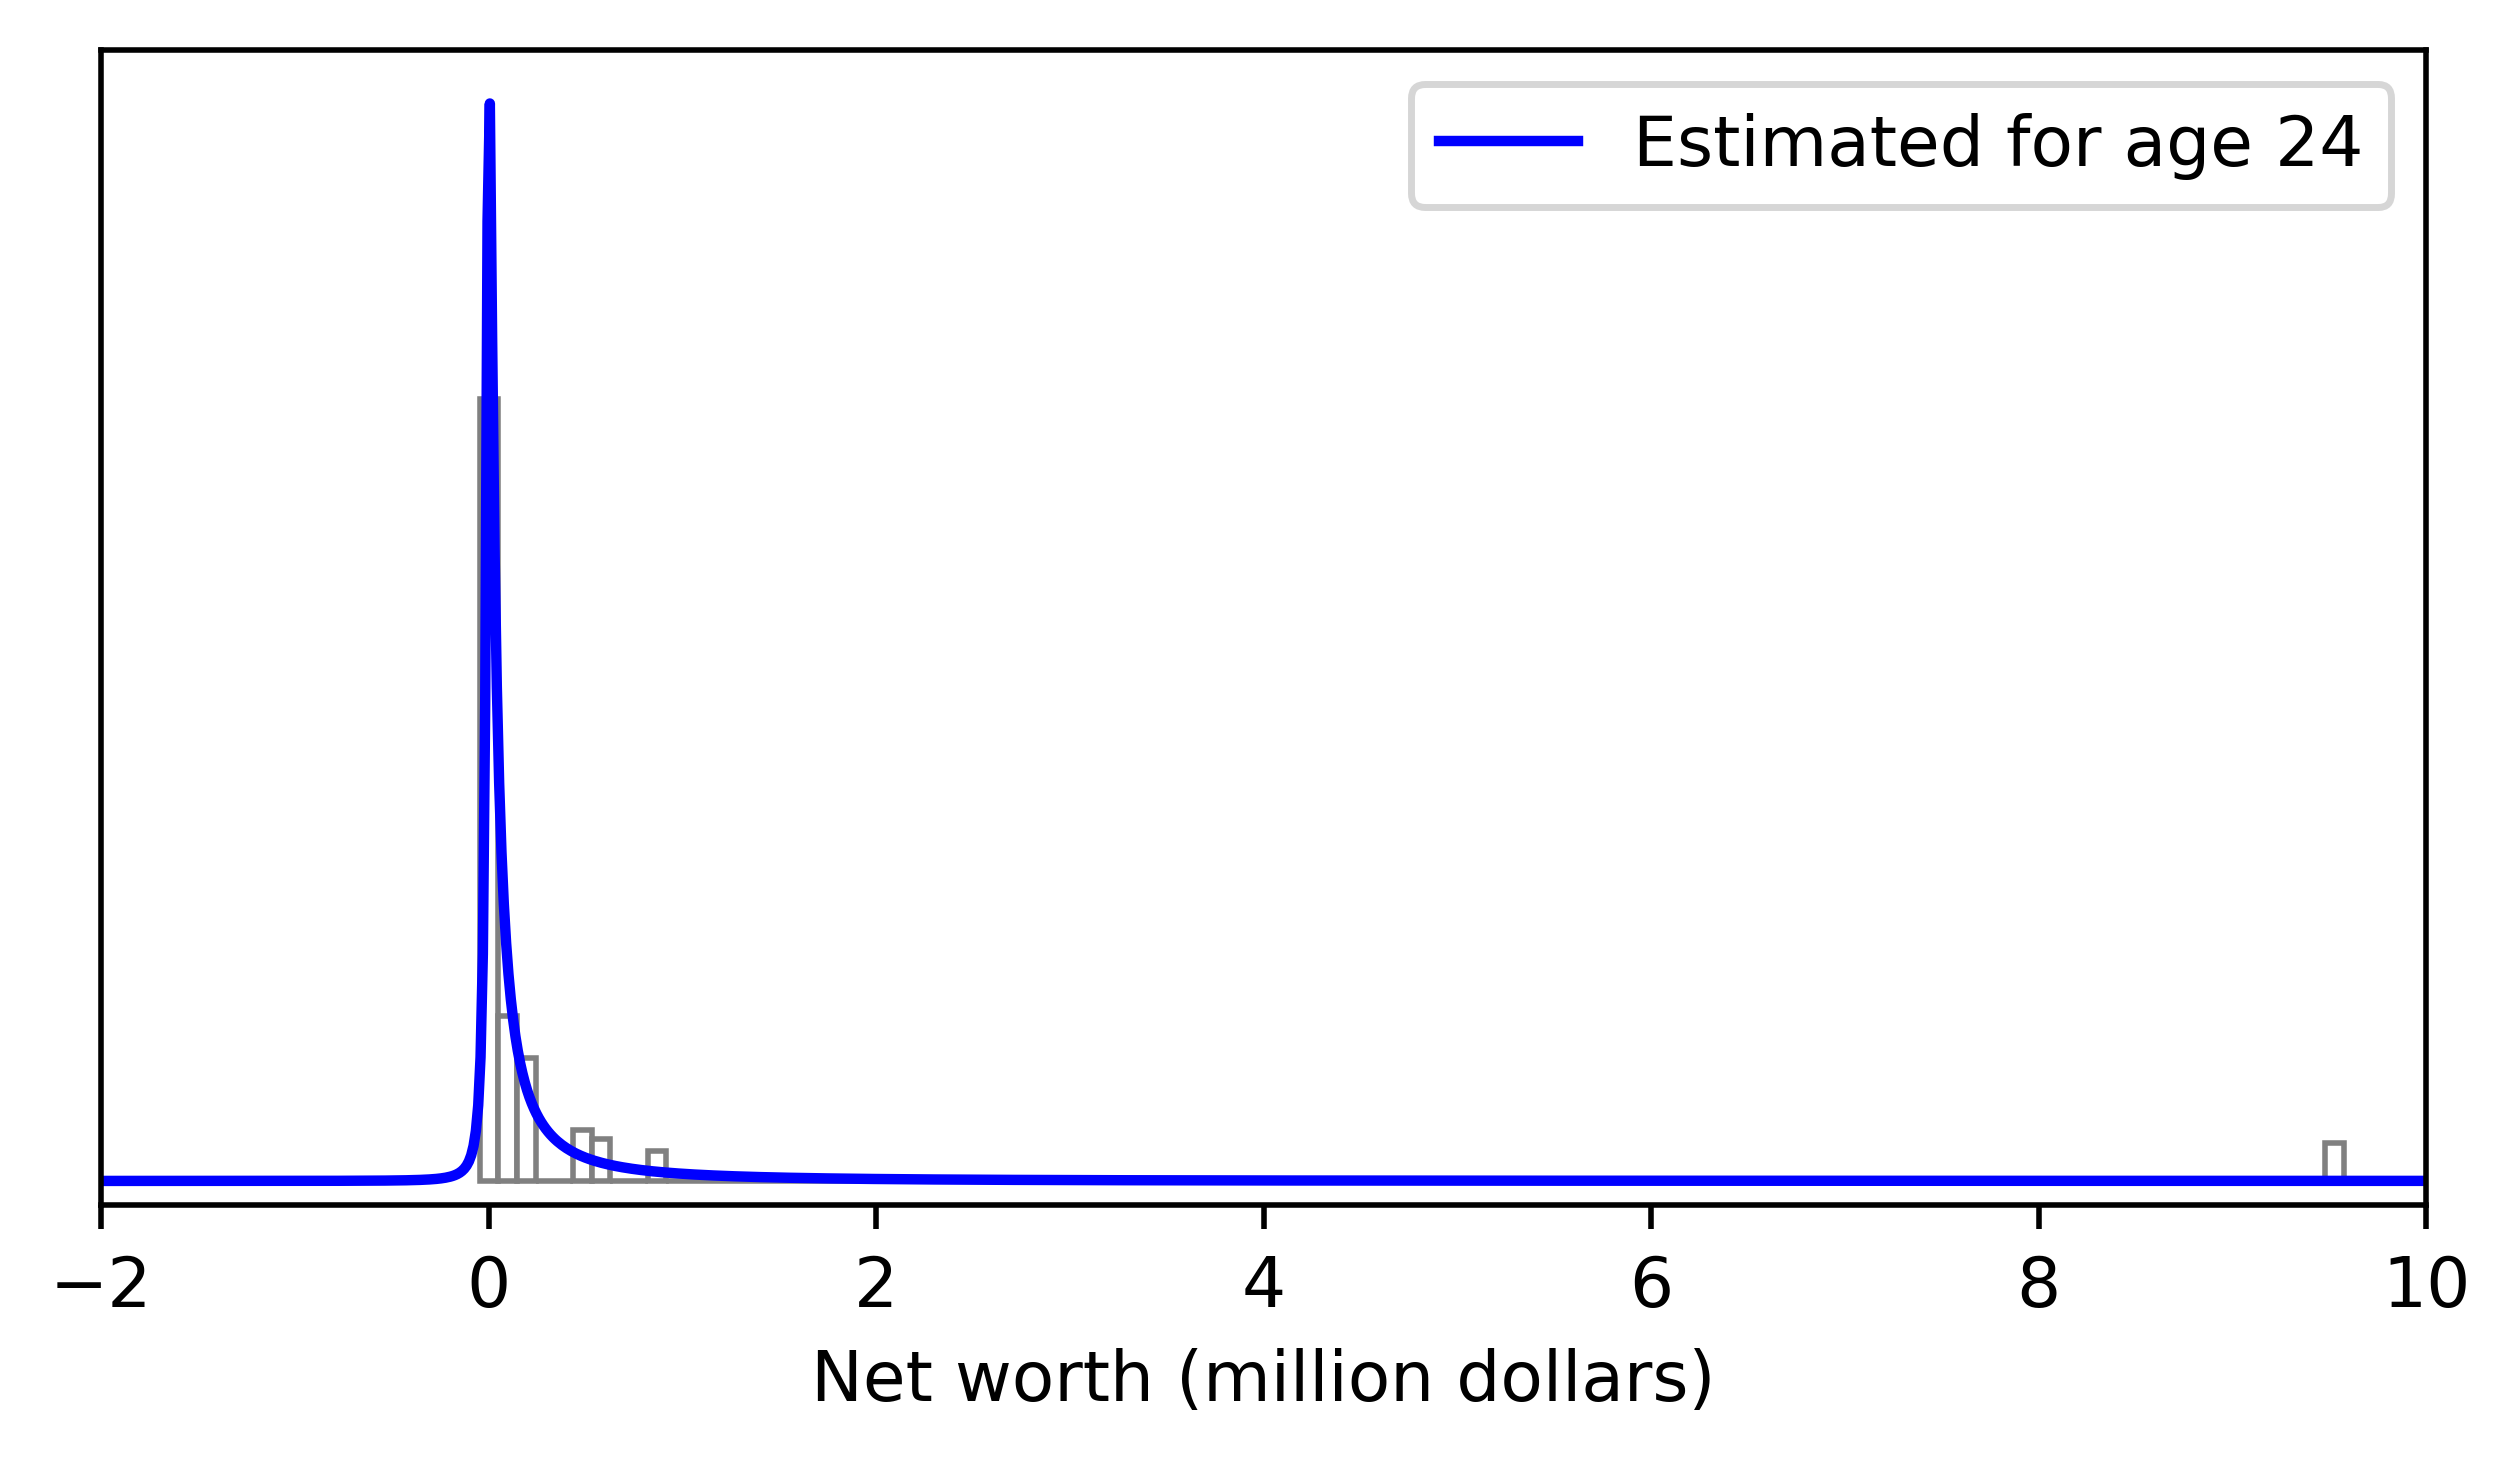

In [40]:
plt.figure(figsize=(6, 3), dpi=500)

plt.xlabel('Net worth (million dollars)')

num_bins = 100
plt.hist(x1_given_x2, num_bins, weights=w_given_x2, density=True,
         linewidth=0.8, color='w', edgecolor='grey')
plt.xlim([-2, 10])

dist_X = np.linspace(-2, 10, 1000)
plt.plot(dist_X, SU_cond_pdf(dist_X, age, m1_MLE, m2_MLE, s1_MLE, s2_MLE,
                             lambda1_MLE, lambda2_MLE, theta1_MLE, theta2_MLE, r_MLE),
         linewidth=1.5, linestyle='solid', color='b', label='Estimated for age 24')

plt.legend(loc='upper right')
plt.ylim(-0.2, None)
plt.yticks([]) # y축 틱 레이블 제거

plt.show()

In [41]:
lambda1_star = lambda1_MLE + r_MLE * theta1_MLE/theta2_MLE *\
                (np.arcsinh((age - m2_MLE) / s2_MLE) - lambda2_MLE)
theta1_star = theta1_MLE * (1 - r_MLE**2)**(1/2)

print('lambda1_star =',lambda1_star)
print('theta1_star =',theta1_star)

lambda1_star = 1.8343232132101701
theta1_star = 1.9494837156271407


In [42]:
model_mean = SU_mean(m1_MLE, s1_MLE, lambda1_star, theta1_star)
model_std = SU_var(m1_MLE, s1_MLE, lambda1_star, theta1_star)**0.5

In [43]:
df_model.loc[age] = {
    'mean': model_mean, 'std': model_std
}
print(df_model.loc[age])

mean    0.309313
std      2.13132
Name: 24, dtype: object


### age 22-24 순자산 분포

**해당 연령 관측만 사용해 계산**

In [44]:
# 필터링된 x1과 weight
x1_given_x2 = x1[(x2 >= 22) & (x2 < 25)]
w_given_x2 = w[(x2 >= 22) & (x2 < 25)]

empirical_mean = weighted_mean(x1_given_x2, w_given_x2)
empirical_std = weighted_std(x1_given_x2, w_given_x2)

df_empirical.loc['22-24'] = {
    'N': len(x1_given_x2)/5, 'min': min(x1_given_x2), 'max': max(x1_given_x2), 
    'mean': empirical_mean, 'std': empirical_std
}
print(df_empirical.loc['22-24'])

N           72.0
min      -0.1556
max       9.5763
mean    0.162699
std     0.923998
Name: 22-24, dtype: object


**Empirical vs. Model-based 분포**

- Random numbers로 분포 추정

In [45]:
import numpy as np

N = 1000000

# 시드 설정
np.random.seed(42)

# 평균 벡터
mean_vector = [lambda1_MLE, lambda2_MLE]

# 공분산 행렬 계산
covariance = r_MLE * theta1_MLE * theta2_MLE
cov_matrix = [[theta1_MLE**2, covariance], [covariance, theta2_MLE**2]]

# 이변량 정규분포에서 샘플 생성
y = np.random.multivariate_normal(mean_vector, cov_matrix, N)
y1 = y[:, 0]
y2 = y[:, 1]

y1 = m1_MLE + s1_MLE * np.sinh(y1)
y2 = m2_MLE + s2_MLE * np.sinh(y2)

# 해당 나이 필터링
y1_given_y2 = y1[(y2 >= 22) & (y2 < 25)]

model_mean = np.mean(y1_given_y2)
model_std = np.std(y1_given_y2)

df_model.loc['22-24'] = {
    'mean': model_mean, 'std': model_std
}
print(df_model.loc['22-24'])

mean    0.323254
std     2.068234
Name: 22-24, dtype: object


In [46]:
m_init = 0
s_init = 0
lambda_init = 0
theta_init = 0

params_init = np.array([m_init, s_init, lambda_init, theta_init])
res_SU = opt.minimize(obj_SU_e, params_init, args=(y1_given_y2,),
                      method='L-BFGS-B')
m_MLE, s_MLE, lambda_MLE, theta_MLE = res_SU.x

s_MLE = np.exp(s_MLE)
theta_MLE = np.exp(theta_MLE)

print('m_MLE =',m_MLE)
print('s_MLE =',s_MLE)
print('lambda_MLE =',lambda_MLE)
print('theta_MLE =',theta_MLE)

m_MLE = -0.004604819307699284
s_MLE = 0.014892711251057636
lambda_MLE = 1.8571540946167868
theta_MLE = 1.9727454590202702


**히스토그램을 random numbers 분포와 비교**

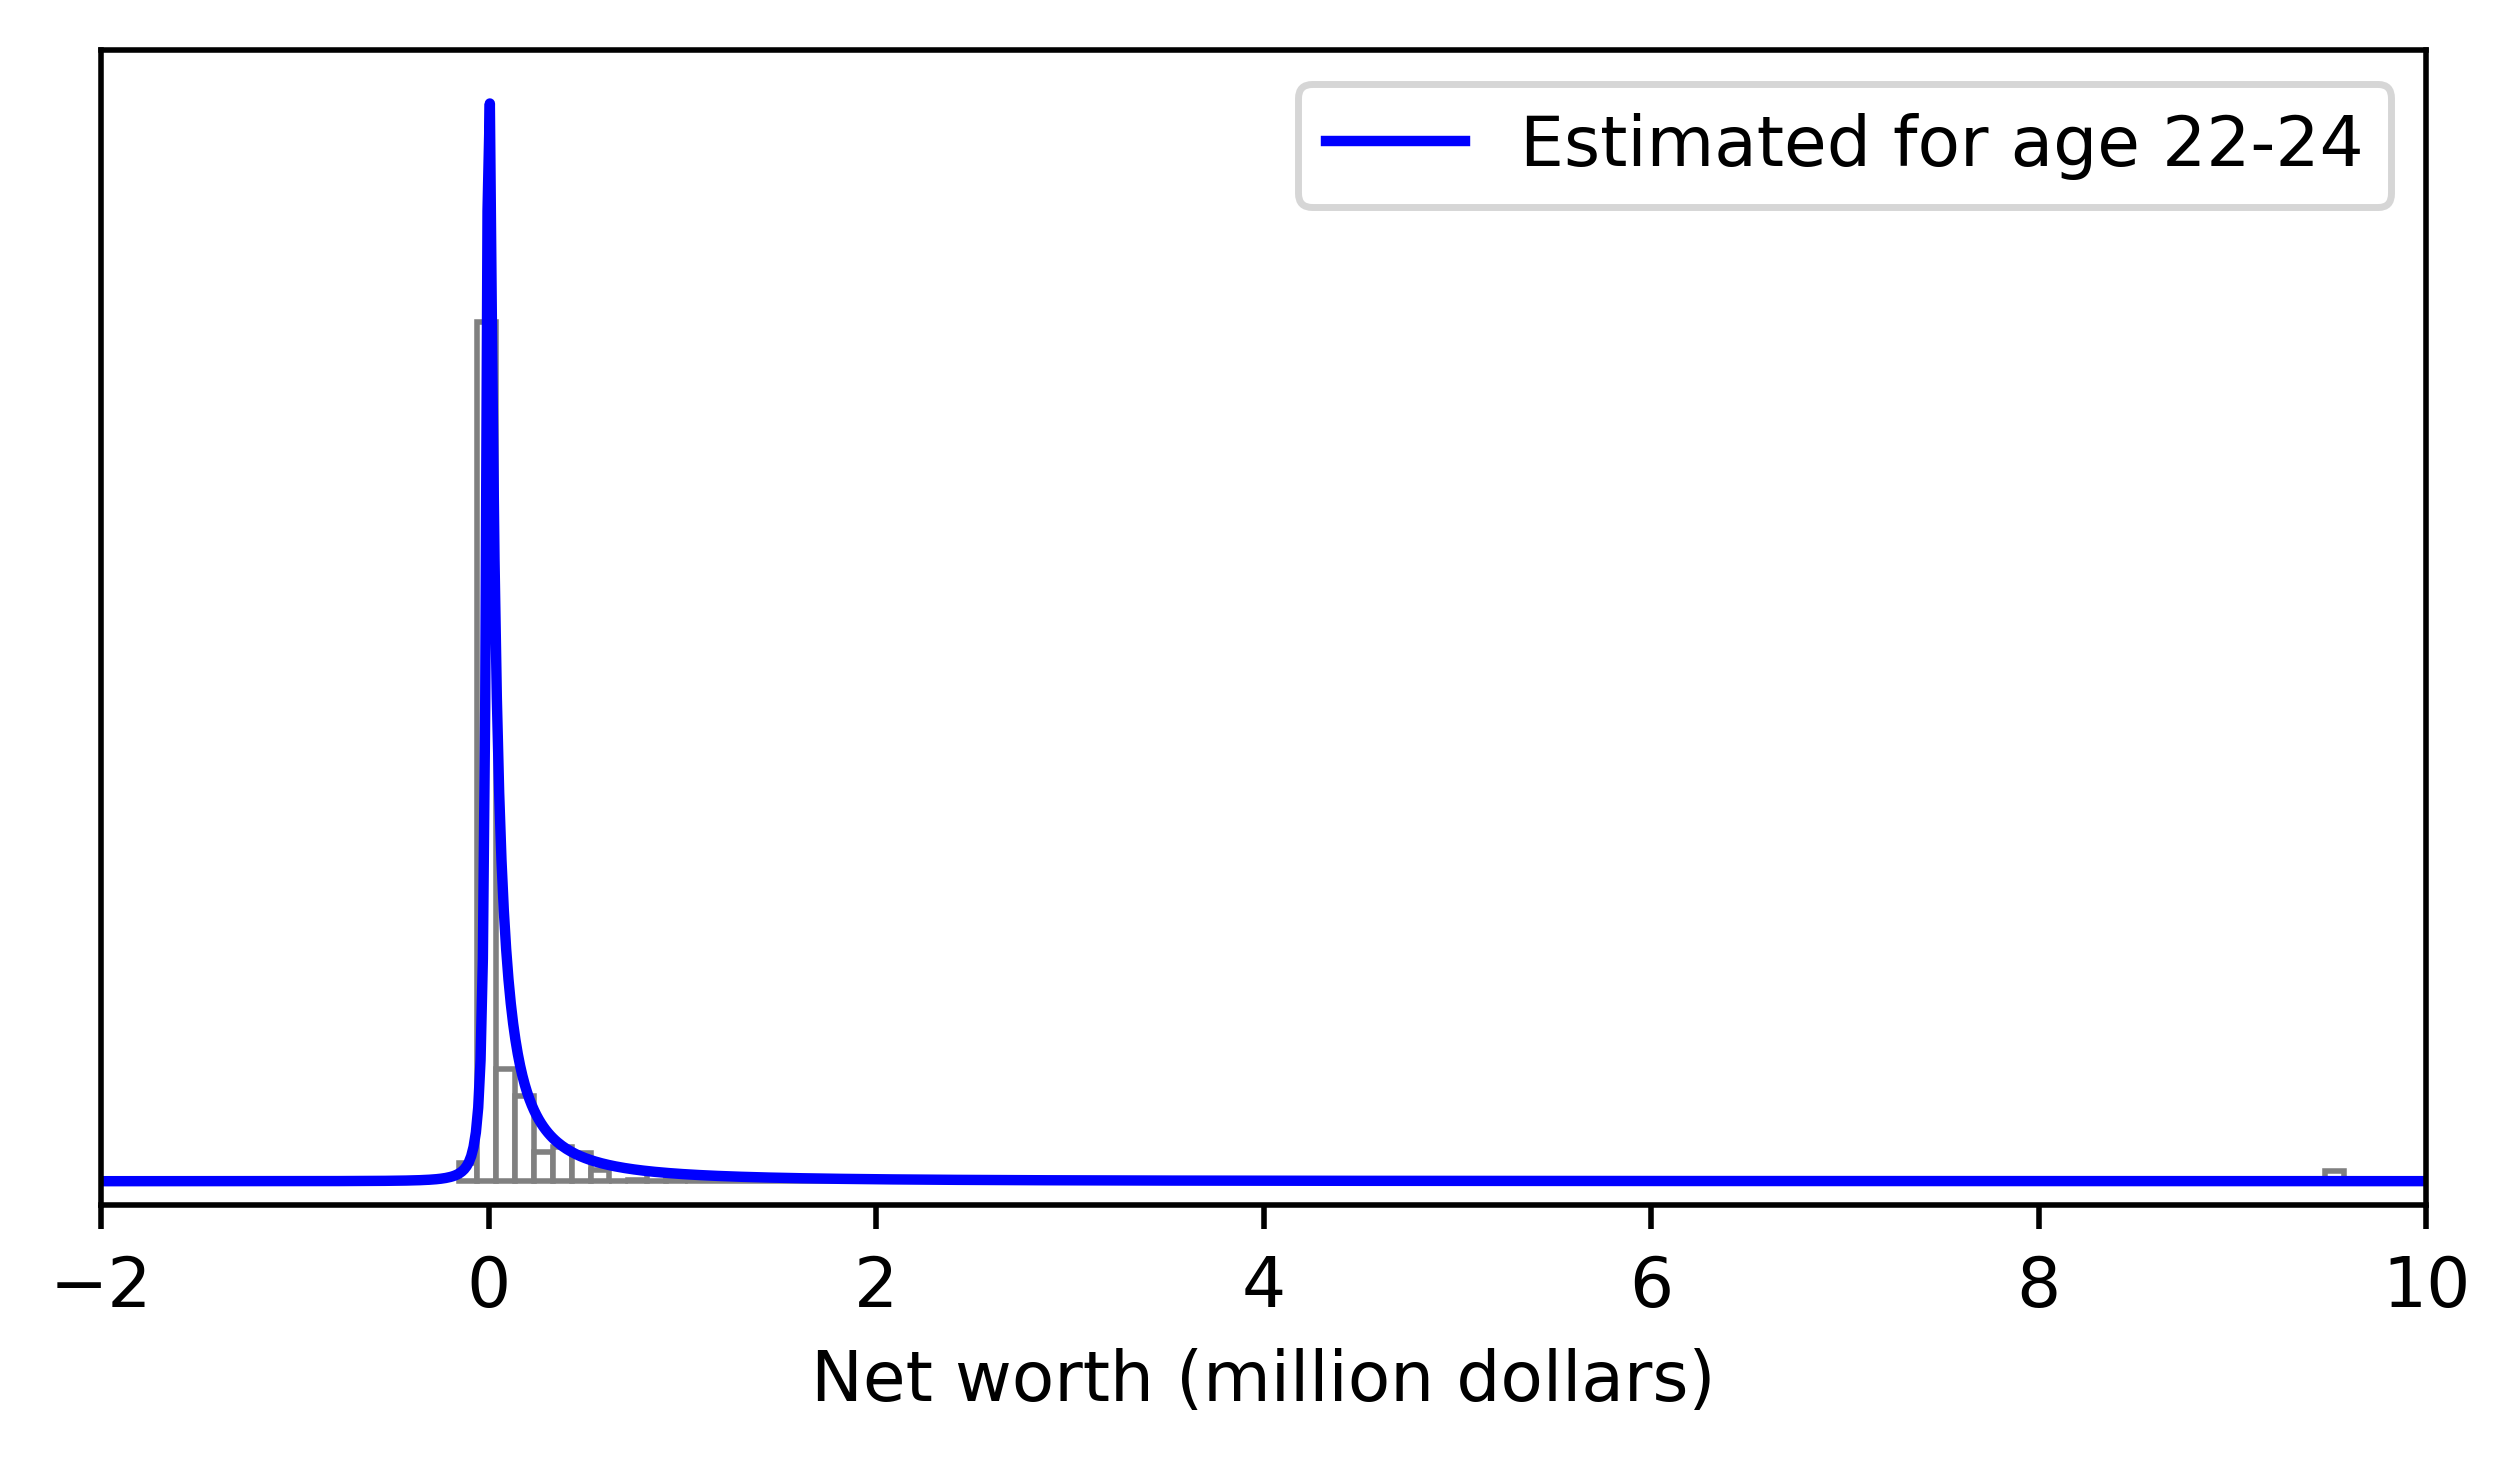

In [47]:
# 히스토그램을 생성
plt.figure(figsize=(6, 3), dpi=500)

plt.xlabel('Net worth (million dollars)')

num_bins = 100
plt.hist(x1_given_x2, num_bins, weights=w_given_x2, density=True,
         linewidth=0.8, color='w', edgecolor='grey')
plt.xlim([-2, 10])

dist_X = np.linspace(-2, 10, 1000)
plt.plot(dist_X, SU_pdf(dist_X, m_MLE, s_MLE, lambda_MLE, theta_MLE),
         linewidth=1.5, linestyle='solid', color='b', label='Estimated for age 22-24')

plt.legend(loc='upper right')
plt.ylim(-0.2, None)
plt.yticks([]) # y축 틱 레이블 제거

plt.show()

**결과 출력 및 저장**

In [48]:
print("Statistics")
df_stats

Statistics


,x1_mean,x1_std,x2_mean,x2_std,Pearson_corr,Normalized_corr
Empirical,1.059457,8.085433,52.447907,17.609608,0.071318,NaN
Model-based,1.355931,11.704146,52.449382,17.663421,0.085214,0.344697


In [49]:
print("Empirical Estimates")
df_empirical

Empirical Estimates


,N,min,max,mean,std
22,24.0,-0.0086,5.4134,0.121863,0.471756
23,27.0,-0.1556,0.4164,0.040808,0.096606
24,21.0,-0.04626,9.5763,0.385618,1.638101
22-24,72.0,-0.1556,9.5763,0.162699,0.923998


In [50]:
print("Model-based Estimates")
df_model

Model-based Estimates


,mean,std
22,0.281579,1.95322
23,0.29517,2.040381
24,0.309313,2.13132
22-24,0.323254,2.068234


## 4. 2022년 상관계수 추정

### Data

In [51]:
year = 2022

In [52]:
x1 = networth_dict[f'networth_{year}']
x1

0        0.7621
1        0.8543
2        0.6782
3        0.2796
4        0.6026
          ...  
22970    0.0000
22971    0.0000
22972    0.0000
22973    0.0000
22974    0.0000
Name: networth, Length: 22975, dtype: float64

In [53]:
x2 = age_dict[f'age_{year}']
x2

0        70
1        70
2        70
3        70
4        70
         ..
22970    40
22971    40
22972    40
22973    40
22974    40
Name: age, Length: 22975, dtype: int8

In [54]:
weight = weight_dict[f'weight_{year}']
w = weight/(weight.sum())

### Empirical Estimates

In [55]:
# x1 통계량
x1_mean = weighted_mean(x1, w)
x1_std = weighted_std(x1, w)

# x2 통계량
x2_mean = weighted_mean(x2, w)
x2_std = weighted_std(x2, w)

# Pearson 상관계수
pearson_corr = weighted_pearson_corr(x1, x2, w)
    
# 결과 출력
result = {'x1_mean': [x1_mean], 'x1_std': [x1_std],
          'x2_mean': [x2_mean], 'x2_std': [x2_std], 
          'Pearson_corr': [pearson_corr]}
df = pd.DataFrame(result)
df.T

,0
x1_mean,1.059457
x1_std,8.085433
x2_mean,52.447907
x2_std,17.609608
Pearson_corr,0.071318


**Empirical 산포도**

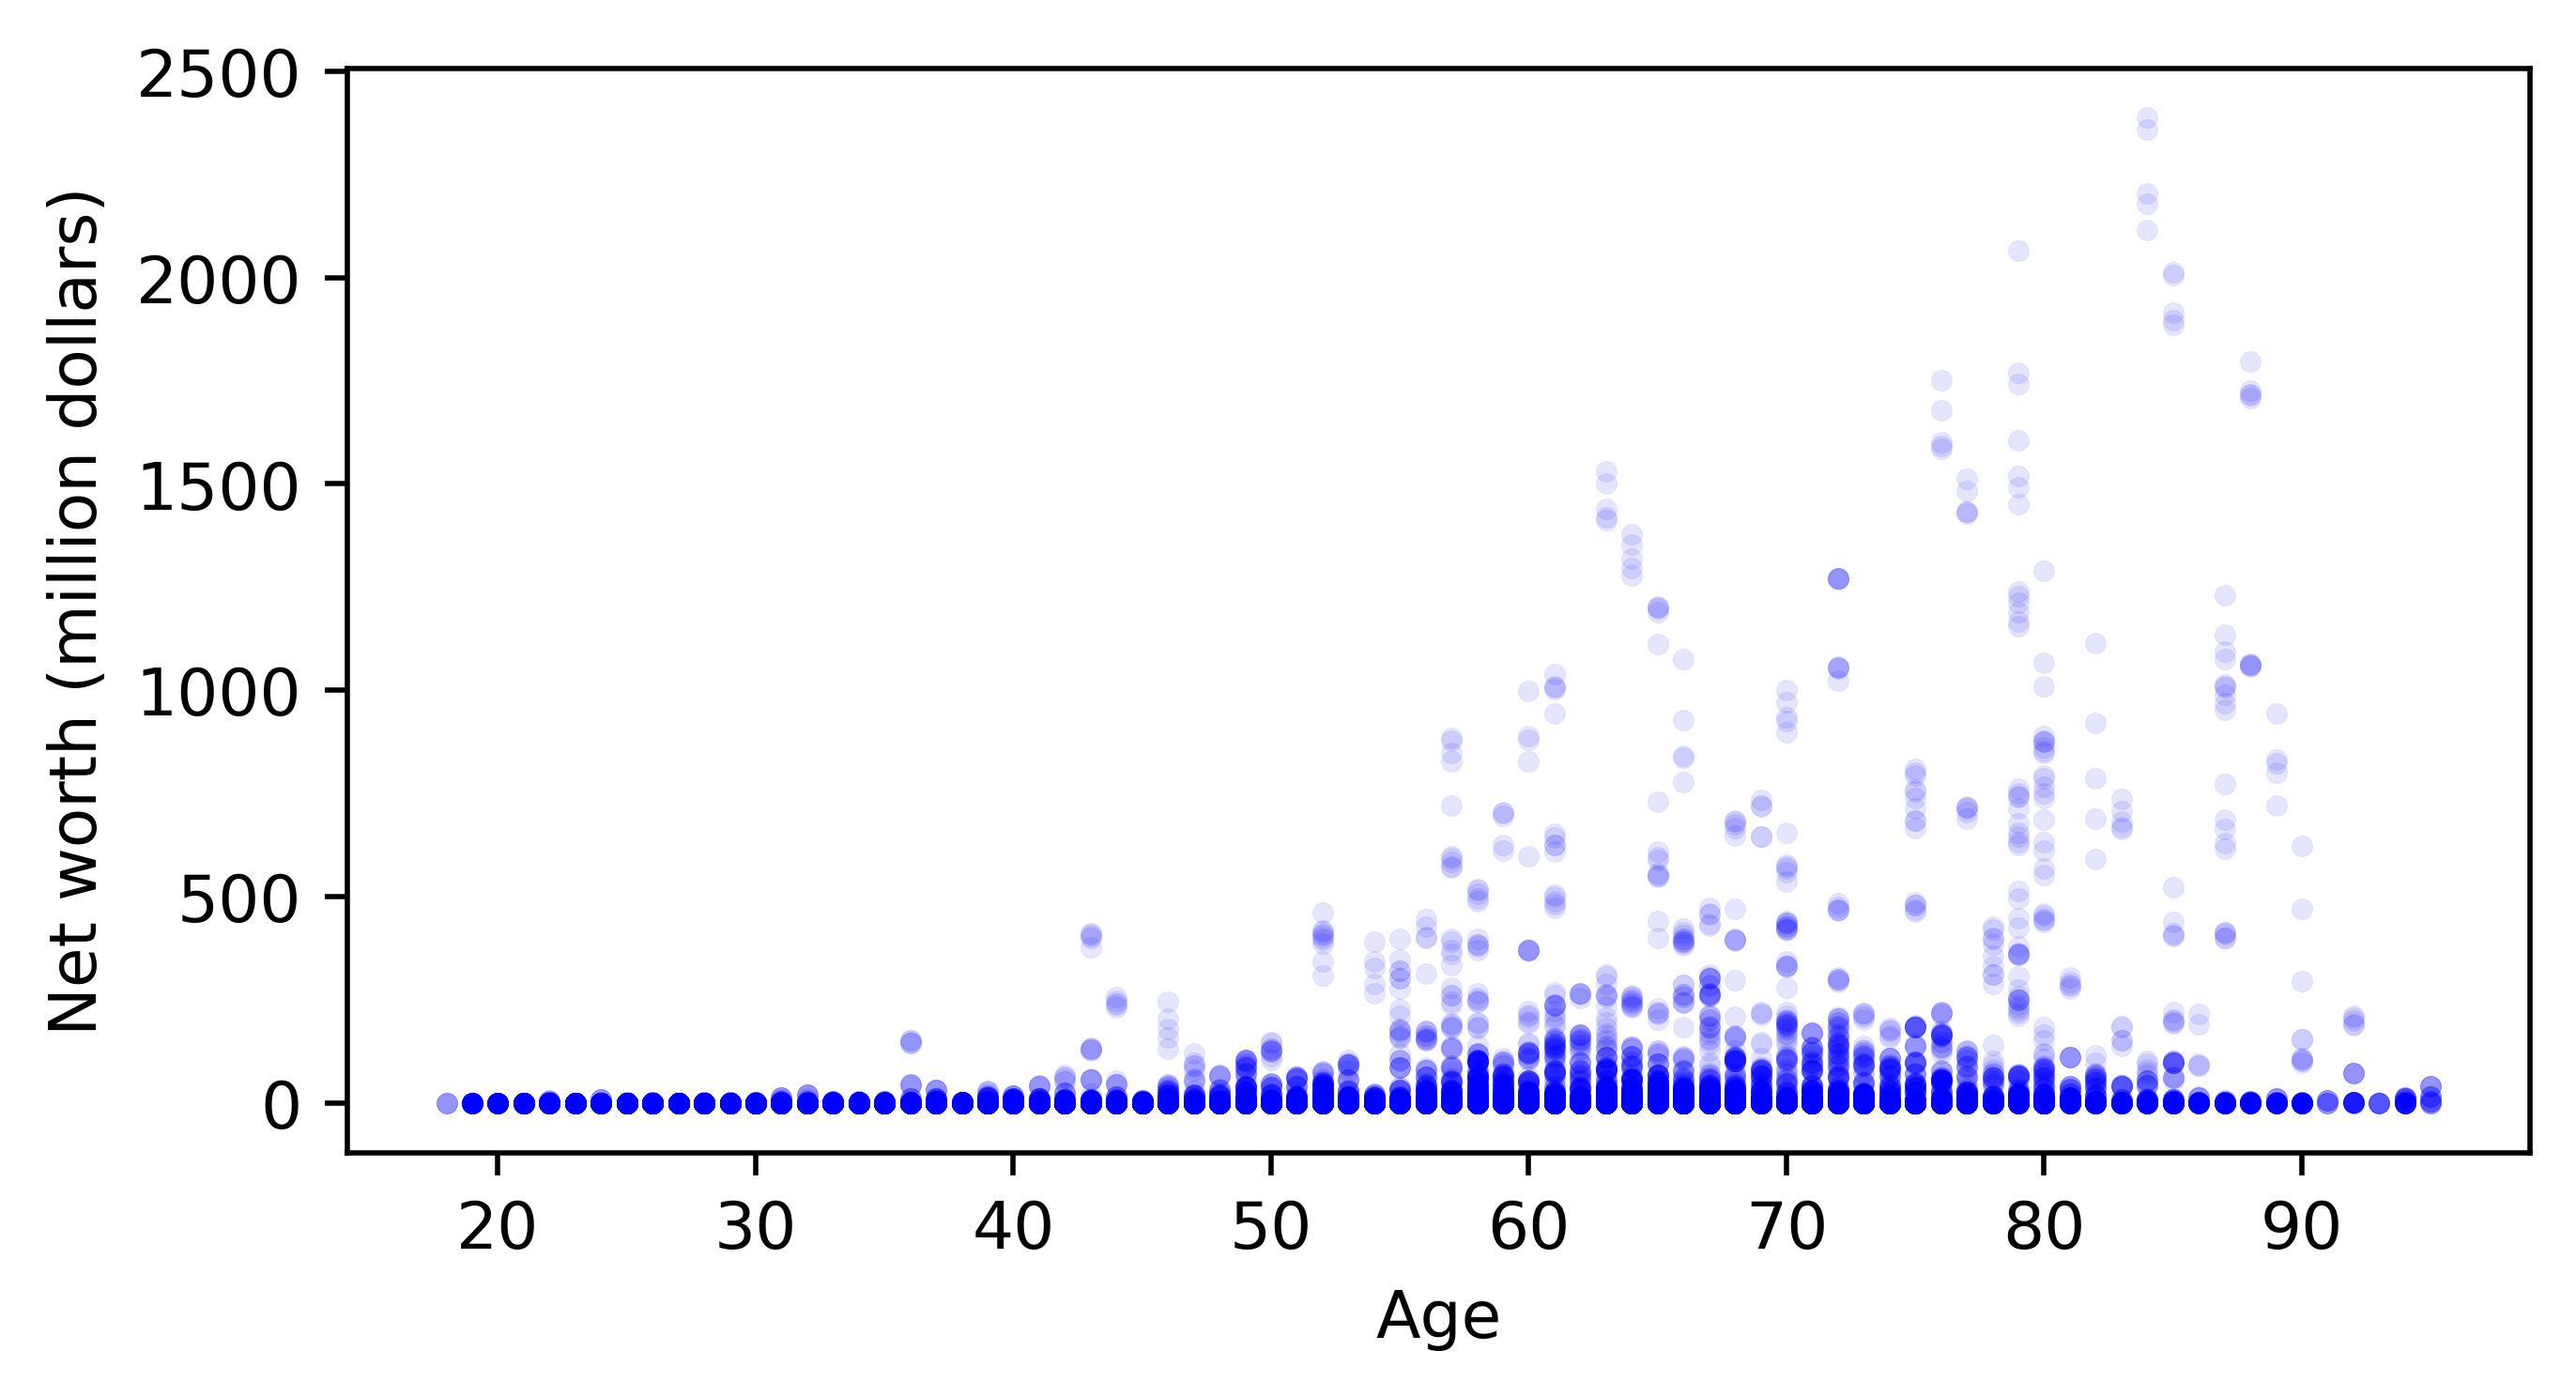

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# 산포도 그리기
plt.figure(figsize=(6, 3), dpi=500) 
plt.scatter(x2, x1, s=10, alpha=0.1, 
            color='b', edgecolor='b', linewidths=.1)
plt.xlabel('Age')
plt.ylabel('Net worth (million dollars)')
plt.show()

### Model-based Estimates

In [57]:
m1_init = 0
s1_init = 0
lambda1_init = 0
theta1_init = 0
m2_init = 0
s2_init = 0
lambda2_init = 0
theta2_init = 0
r = 0
params_init = np.array([m1_init, s1_init, lambda1_init, theta1_init,
                       m2_init, s2_init, lambda2_init, theta2_init, r])
mle_args = (x1,x2,w)
res_bi_SU = opt.minimize(weight_obj_bi_SU_e, params_init, args=mle_args,
                         method='L-BFGS-B',
                         bounds=[(None, None)] * 8 + [(-.99, .99)])

(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE,
 m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE, r_MLE)=res_bi_SU.x

s1_MLE = np.exp(s1_MLE)
theta1_MLE = np.exp(theta1_MLE)
s2_MLE = np.exp(s2_MLE)
theta2_MLE = np.exp(theta2_MLE)

# 결과 출력
result = {'m1': [m1_MLE], 's1': [s1_MLE],
          'lambda1': [lambda1_MLE], 'theta1': [theta1_MLE],
          'm2': [m2_MLE], 's2': [s2_MLE],
          'lambda2': [lambda2_MLE], 'theta2': [theta2_MLE], 'r': [r_MLE]}
df = pd.DataFrame(result)
df.T

,0
m1,-0.004508
s1,0.015383
lambda1,3.021377
theta1,2.076760
m2,-2.300825
s2,123.780052
lambda2,0.425655
theta2,0.129500
r,0.344697


In [58]:
res_bi_SU

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.747951188349125
        x: [-4.508e-03 -4.175e+00  3.021e+00  7.308e-01 -2.301e+00
             4.819e+00  4.257e-01 -2.044e+00  3.447e-01]
      nit: 123
      jac: [ 1.405e-04  1.082e-04  2.824e-05  2.035e-04  5.258e-05
             7.763e-05  2.538e-04 -8.358e-05  2.203e-04]
     nfev: 1500
     njev: 150
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [59]:
# x1 통계량
x1_mean = SU_mean(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE)
x1_std = SU_var(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE)**0.5

# x2 통계량
x2_mean = SU_mean(m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE)
x2_std = SU_var(m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE)**0.5

# Pearson 상관계수
pearson_corr = SU_P_corr(lambda1_MLE, lambda2_MLE, theta1_MLE, theta2_MLE, r_MLE)

# Normalized_corr
Normalized_corr = r_MLE

In [60]:
# 결과 출력
result = {'x1_mean': [x1_mean], 'x1_std': [x1_std], 
          'x2_mean': [x2_mean], 'x2_std': [x2_std], 
          'Pearson_corr': [pearson_corr], 'Normalized_corr': [Normalized_corr]}
df = pd.DataFrame(result)
df.T

,0
x1_mean,1.355931
x1_std,11.704146
x2_mean,52.449382
x2_std,17.663421
Pearson_corr,0.085214
Normalized_corr,0.344697


**Normalized 산포도**

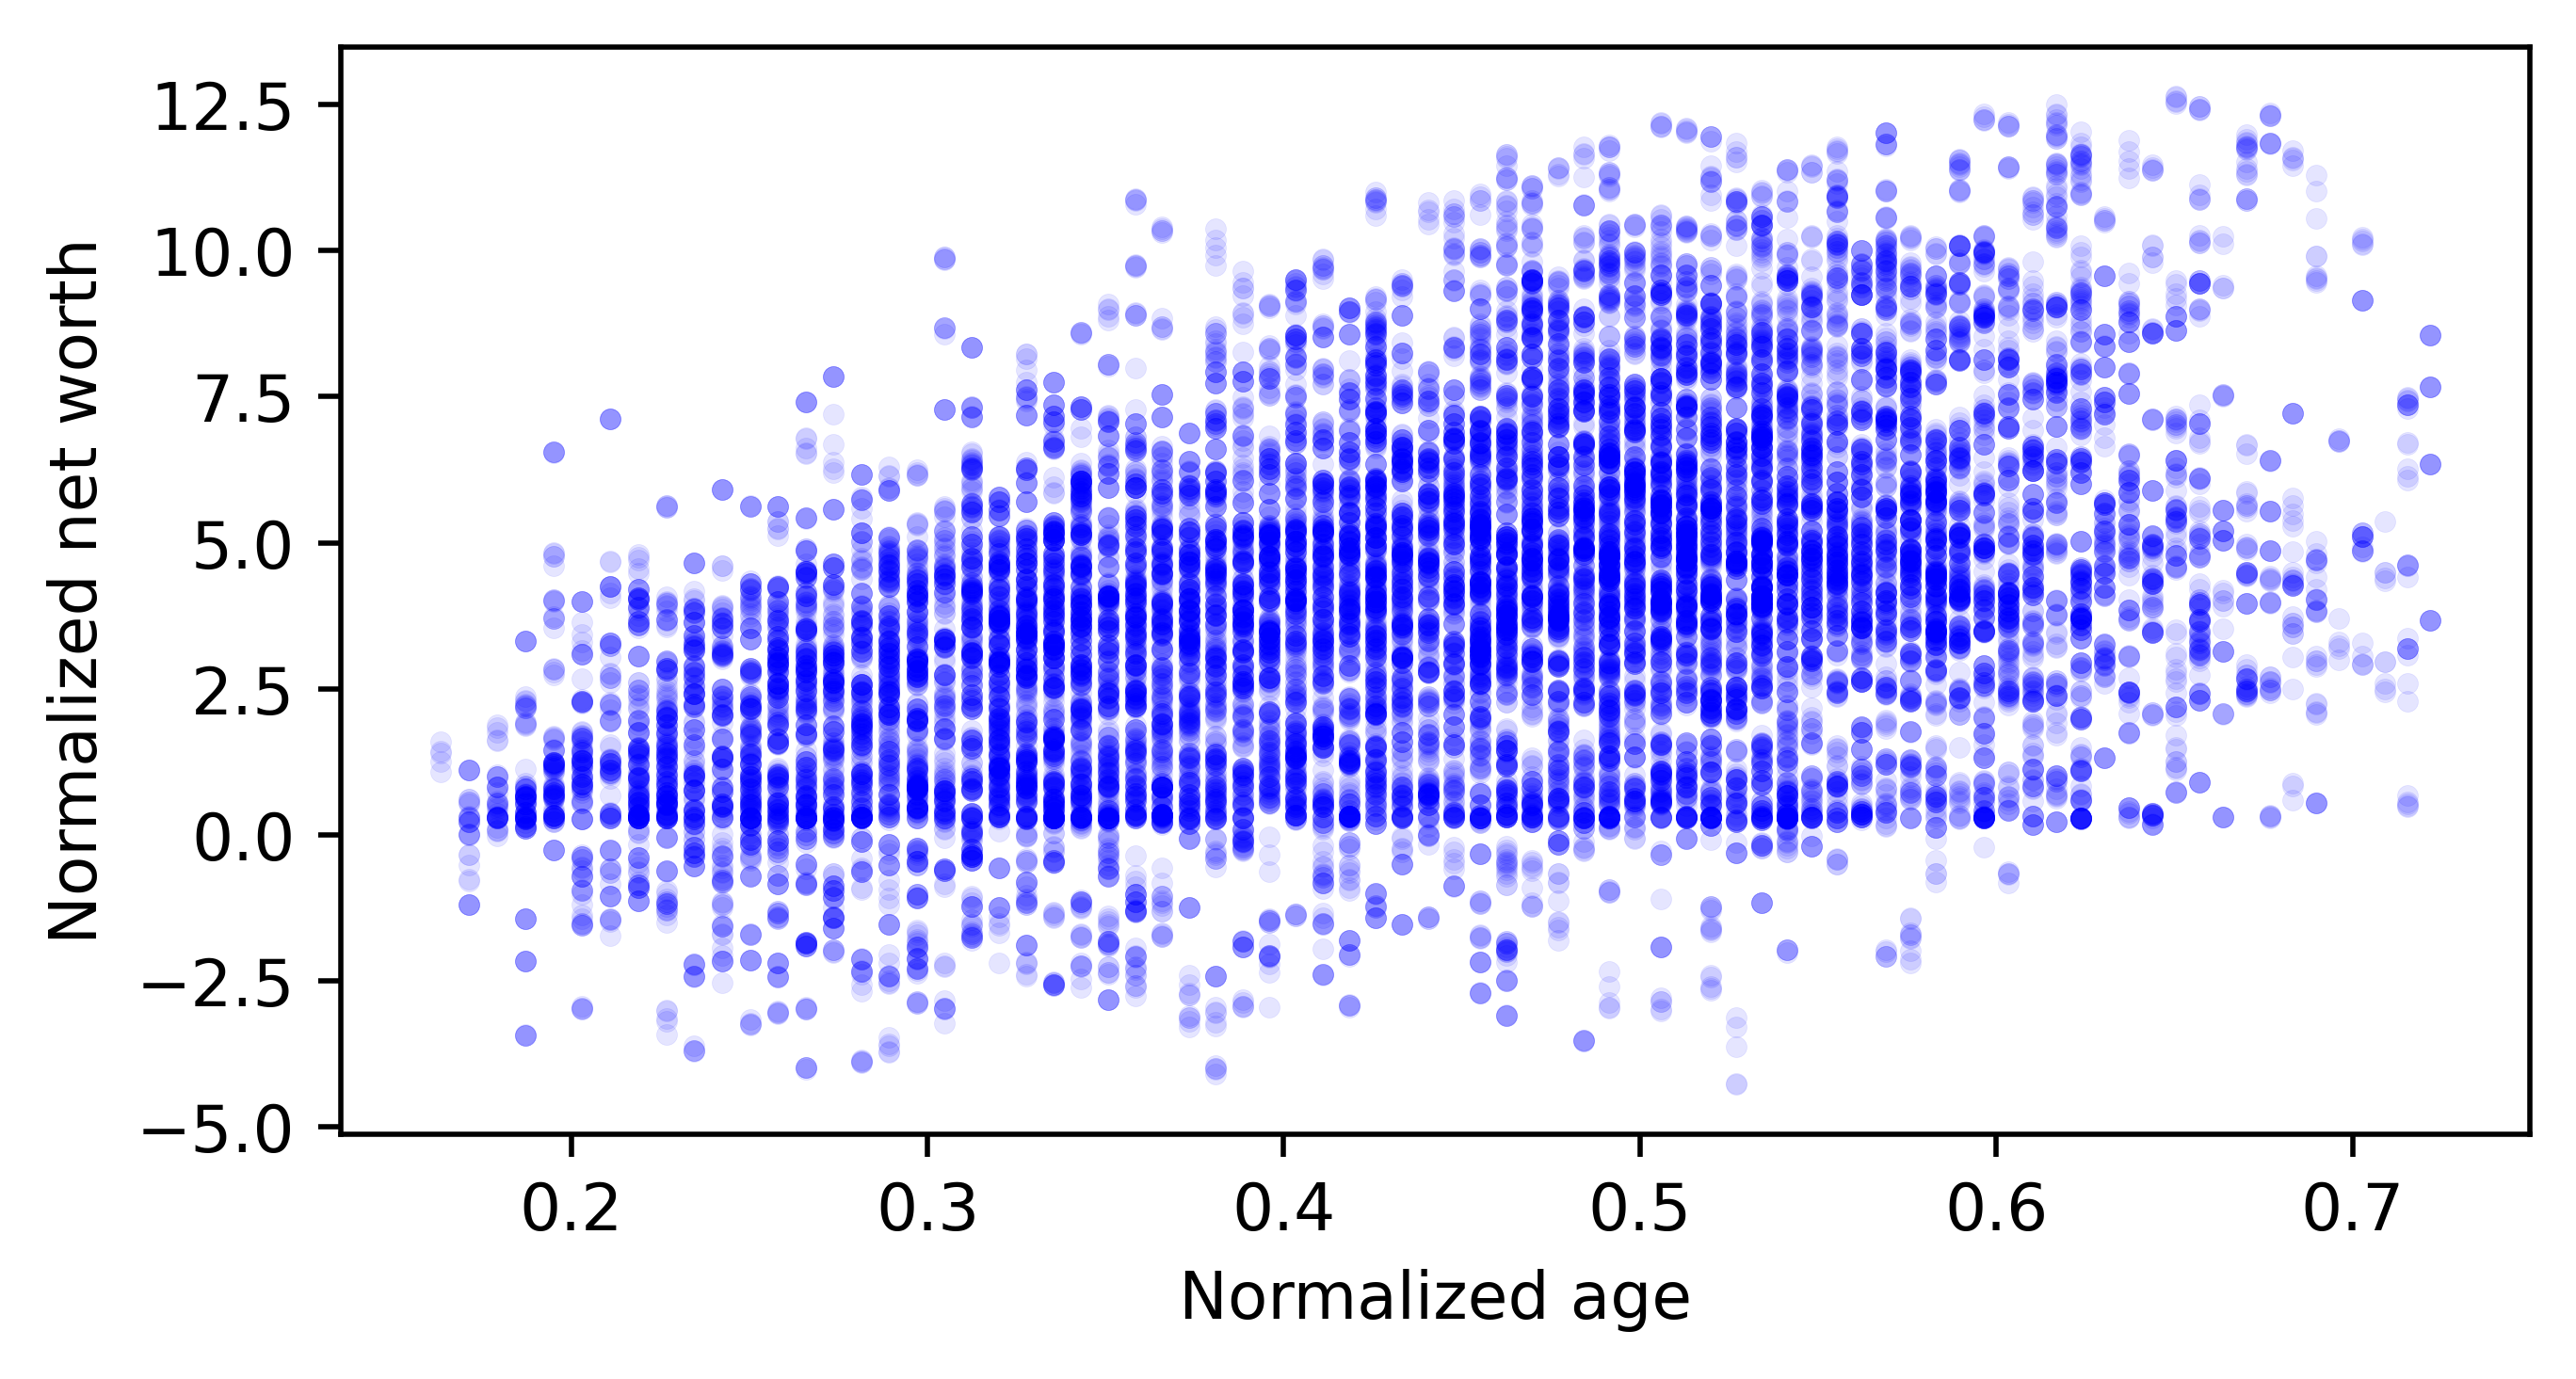

In [61]:
normalized_x1 = np.arcsinh((x1 - m1_MLE)/s1_MLE)
normalized_x2 = np.arcsinh((x2 - m2_MLE)/s2_MLE)

# 산포도 그리기
plt.figure(figsize=(6, 3), dpi=500) 
plt.scatter(normalized_x2, normalized_x1, s=10, alpha=0.1, 
            color='b', edgecolor='b', linewidths=.1)
plt.xlabel('Normalized age')
plt.ylabel('Normalized net worth')
plt.show()

## 5. 연도별 Gini 및 상관계수 추정

**Empty Dataframe**

In [62]:
columns = ['m1', 's1', 'lambda1', 'theta1', 'm2', 's2', 'lambda2', 'theta2', 'r']
df_parameters = pd.DataFrame(columns=columns, index=range(1989, 2023, 3))

columns = ['x1_mean', '22_mean', '1989-22_mean',
           'Pearson_corr', 'Normalized_corr']
df_model = pd.DataFrame(columns=columns, index=range(1989, 2023, 3))

**Model-based Estimates**

In [63]:
for year in range(1989, 2023, 3):

    # Data
    x1 = networth_dict[f'networth_{year}']
    x2 = age_dict[f'age_{year}']
    weight = weight_dict[f'weight_{year}']
    w = weight/(weight.sum())

    m1_init = 0
    s1_init = 0
    lambda1_init = 0
    theta1_init = 0
    m2_init = 0
    s2_init = 0
    lambda2_init = 0
    theta2_init = 0
    r = 0
    params_init = np.array([m1_init, s1_init, lambda1_init, theta1_init,
                            m2_init, s2_init, lambda2_init, theta2_init, r])
    mle_args = (x1,x2,w)
    res_bi_SU = opt.minimize(weight_obj_bi_SU_e, params_init, args=mle_args,
                             method='L-BFGS-B',
                             bounds=[(None, None)] * 8 + [(-.99, .99)])

    (m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE,
     m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE, r_MLE)=res_bi_SU.x

    s1_MLE = np.exp(s1_MLE)
    theta1_MLE = np.exp(theta1_MLE)
    s2_MLE = np.exp(s2_MLE)
    theta2_MLE = np.exp(theta2_MLE)

    # Parameters
    df_parameters.loc[year] = {
        'm1': m1_MLE, 's1': s1_MLE, 
        'lambda1': lambda1_MLE, 'theta1': theta1_MLE, 
        'm2': m2_MLE, 's2': s2_MLE,
        'lambda2': lambda2_MLE, 'theta2': theta2_MLE, 'r': r_MLE
    }

    # x1 통계량
    x1_mean = SU_mean(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE)
    x1_std = SU_var(m1_MLE, s1_MLE, lambda1_MLE, theta1_MLE)**0.5

    # x2 통계량
    x2_mean = SU_mean(m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE)
    x2_std = SU_var(m2_MLE, s2_MLE, lambda2_MLE, theta2_MLE)**0.5

    # Pearson 상관계수
    pearson_corr = SU_P_corr(lambda1_MLE, lambda2_MLE, theta1_MLE, theta2_MLE, r_MLE)

    # Normalized_corr
    Normalized_corr = r_MLE

    # 표에 결과 입력
    df_model.loc[year] = {
        'x1_mean': x1_mean,
        'Pearson_corr': pearson_corr, 'Normalized_corr': Normalized_corr
    }
    
    #######
    # Age 22
    #######

    age = 22
    
    lambda1_star = lambda1_MLE + r_MLE * theta1_MLE/theta2_MLE *\
                    (np.arcsinh((age - m2_MLE) / s2_MLE) - lambda2_MLE)
    theta1_star = theta1_MLE * (1 - r_MLE**2)**(1/2)

    model_mean = SU_mean(m1_MLE, s1_MLE, lambda1_star, theta1_star)
    model_std = SU_var(m1_MLE, s1_MLE, lambda1_star, theta1_star)**0.5

    # 표에 결과 입력
    df_model.loc[year, '22_mean'] = model_mean    

    #######
    # Age 1989-22
    #######

    age = year - 1989 + 22

    lambda1_star = lambda1_MLE + r_MLE * theta1_MLE/theta2_MLE *\
                    (np.arcsinh((age - m2_MLE) / s2_MLE) - lambda2_MLE)
    theta1_star = theta1_MLE * (1 - r_MLE**2)**(1/2)

    model_mean = SU_mean(m1_MLE, s1_MLE, lambda1_star, theta1_star)
    model_std = SU_var(m1_MLE, s1_MLE, lambda1_star, theta1_star)**0.5

    # 표에 결과 입력
    df_model.loc[year, '1989-22_mean'] = model_mean    
    
print("Parameter Estimates")
df_parameters

Parameter Estimates


,m1,s1,lambda1,theta1,m2,s2,lambda2,theta2,r
1989,-0.003479,0.00512,3.429398,2.067407,2.447654,0.0,22.495757,0.399396,0.377011
1992,-0.003947,0.006971,3.141477,1.912725,1.605395,0.000031,14.843537,0.385133,0.398829
1995,-0.005457,0.009576,2.965569,1.77151,0.9573,0.0081,9.301122,0.376712,0.388821
1998,-0.005301,0.011286,2.907433,1.890287,0.331102,9.1183,2.308837,0.361031,0.415625
2001,-0.004258,0.009097,3.242241,2.012711,0.379649,8.615925,2.369519,0.359082,0.404885
2004,-0.004198,0.009824,3.185591,2.043998,-9.99746,0.126435,6.805184,0.296185,0.401375
2007,-0.004939,0.010898,3.166774,2.053346,0.361634,8.611763,2.391972,0.35835,0.416983
2010,-0.001217,0.012317,2.620027,2.238396,-0.726524,37.269039,1.094492,0.270843,0.413398
2013,-0.001629,0.012473,2.58753,2.220089,-0.799667,48.971463,0.903052,0.241717,0.390404
2016,-0.002583,0.012433,2.735466,2.244285,-1.026549,68.13947,0.69974,0.200593,0.421171


In [64]:
print("Model-based Estimates")
df_model

Model-based Estimates


,x1_mean,22_mean,1989-22_mean,Pearson_corr,Normalized_corr
1989,0.665254,0.104716,0.104716,0.104431,0.377011
1992,0.497509,0.076292,0.103095,0.139094,0.398829
1995,0.439558,0.080945,0.134701,0.161833,0.388821
1998,0.609594,0.085317,0.189154,0.149504,0.415625
2001,0.87667,0.11466,0.315112,0.12195,0.404885
2004,0.953466,0.128047,0.394228,0.113493,0.401375
2007,1.057712,0.113288,0.495903,0.118724,0.416983
2010,1.029273,0.093143,0.480617,0.08359,0.413398
2013,0.967733,0.111177,0.546734,0.079882,0.390404
2016,1.181642,0.113663,0.688553,0.081265,0.421171
